# A/B Testing Project: Free Trial Screener

This work was based on the final project from the A/B Testing course that I took at Udacity in September 2018.  

# Part I: Experiment Overview 

In the experiment, Udacity wanted to test a change at its website where if a student clicked "Start free trial" button after viewing a course overview page, she would be asked how much time she had available to devote to that course. This screenshot shows what the message looked like.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from PIL import Image
from scipy import stats

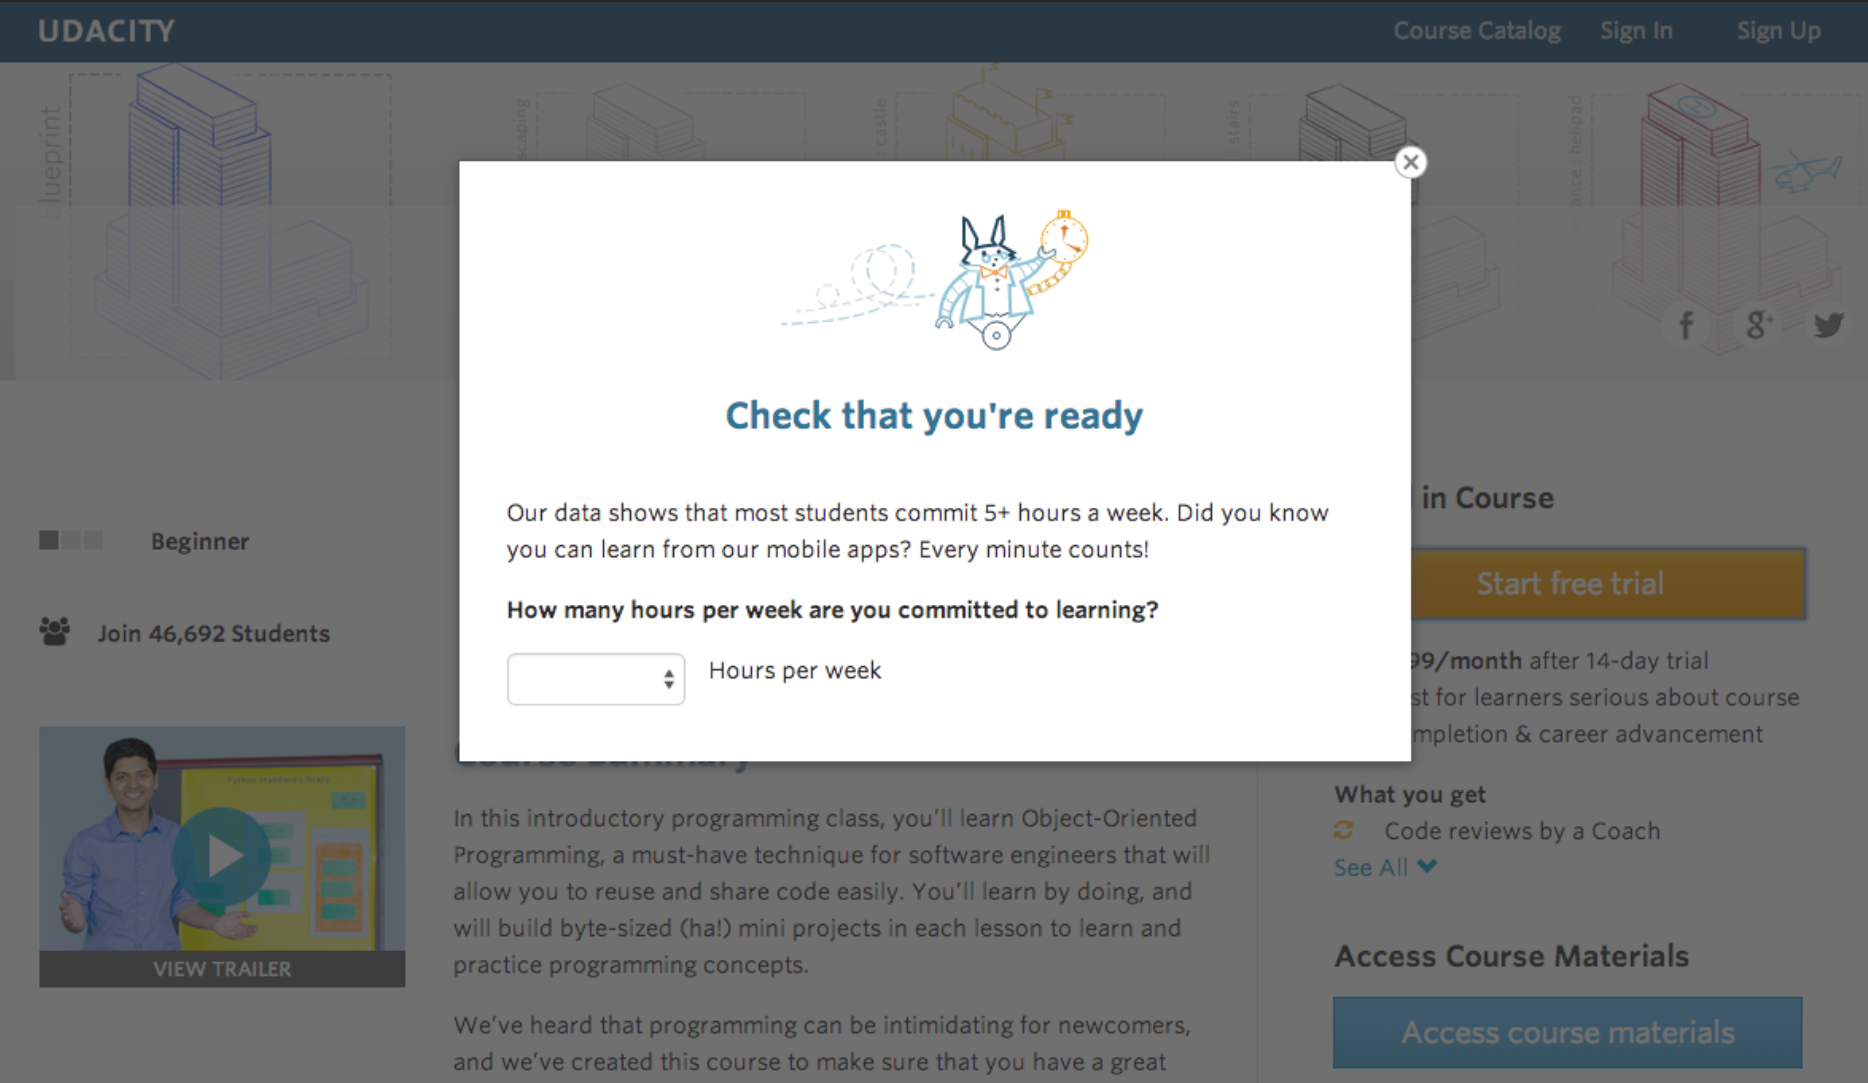

In [2]:
Image.open('free trial screener.png')

If the student indicated 5 or more hours per week, then she would be taken through the checkout process as usual. After 14 days, she will automatically be charged unless she cancels first. If she indicated fewer than 5 hours per week, a message would appear suggesting the student access the course materials for free. 

The hypothesis was that this free trial screener might set clearer expectations for students upfront, thus _reducing_ the number of frustrated students who left the free trial because they didn't have enough time. 

A detailed project overview can be found at: [Final Project Instructions](https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True). 

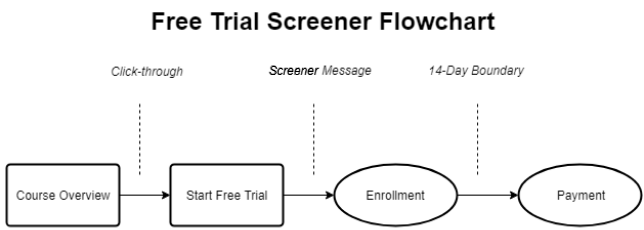

In [3]:
Image.open('flowchart1.png')

## Part II: Experiment Design

### Metric Choice

#### 1. Unit of Diversion

The unit of diversion is a **cookie**, but as soon as a student enrolls in the free trial, he or she will be tracked by user-id moving forward. 

#### 2. Unit of Analysis 

In [4]:
# Import data frame for baseline values 
baseline = pd.read_csv('final_project_baseline_values.csv')
baseline

,Evaluation_metric,Baseline_value
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,Gross conversion,0.206250
5,Retention,0.530000
6,Net Conversion,0.109313


The unit of anlysis is the denominator of a metric, and thus every metric has its own unit of analysis as below. 

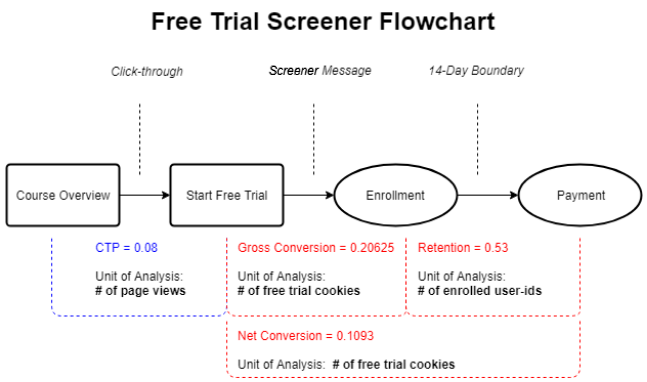

In [5]:
Image.open('flowchart.png')

#### 3. Invariant Metrics

An invariant metric is used in the sanity check during A/B Testing, which should stay consistent before and after the experiment. 

In this project, since the experimental message would not show up until a student press the "Start free trial" button, any metric collected before the enrollment step would not be affected by the experiment. As a result, I chose  **number of cookies**, **number of clicks**, and **click-through probability** to be the invariant metrics.  

#### 4. Evaluation Metrics

An evaluation metric is used to measure the business impact of an experiment.

Looking at the definitions of the given metrics, the **Gross Conversion** rate would give us an idea on the percentage of students who eventually enrolled in the free trial after seeing the pop-up experimental message. We would expect to see a _negative_ change in this metric in the experiment, indicating the message reduced the frustrated students. 

The **Retention** rate would be a good evaluation metric as well, because it reflects the percentage of students who made at least one payment after the enrollment which would be affected by the experimental message. I would expect a _positive_ change in this metric assuming students enrolled have been aware of the time that should be committed to the courses.  

Last but not least, the **Net Conversion** rate should also be included, as it shows us the percentage of students who made at least one payment out of the total number of cookies to click the "Start free trial" where students would see the experimental message. As with the Gross Conversion rate, I would expect to see a negative change in this metric. 

### Measuring Standard Deviation

For each evaluation metric, we are asked to calculate the **analytic estimate** standard deviation, given a sample of 5000 cookies visiting the course overview page and the [baseline values](https://docs.google.com/spreadsheets/d/1MYNUtC47Pg8hdoCjOXaHqF-thheGpUshrFA21BAJnNc/edit#gid=0). It should be noted that we are in fact measuring the standard error of sample mean. 

In [6]:
# Number of Cookies
baseline_cookies = baseline.values[0,1]

# Number of Free Trial Cookies
baseline_free_trial_cookies = baseline.values[1,1]

# Click-through Probability
CTP = baseline.values[3,1]

# Gross Conversion
baseline_gc = baseline.values[4,1]

# Retetion 
baseline_rt = baseline.values[5,1]

# Net Conversion
baseline_nc = baseline.values[6,1]

# Sample Size 
sample_size = 5000

Calculate the value of unit of analysis for each metric based on the given sample size: 

In [7]:
# Number of free trial cookies
free_trial_cookies = sample_size*CTP
free_trial_cookies

400.0

In [8]:
# Number of enrolled user-ids
enrolled_user_ids = free_trial_cookies*baseline_gc
enrolled_user_ids

82.5

Assuming that the data are independent and identically distributed (i.i.d.) and there are only two outcomes for every event, we can conclude the data follow a _Bernoulli_ distribution. The analytic standard error can be calculated using the following formula: 

$$ {s}_\bar{x} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$$

In [9]:
# se for Gross Conversion 
se_hat_gc = np.sqrt(baseline_gc*(1-baseline_gc)*(1/free_trial_cookies))
se_hat_gc

0.020230604137049392

In [10]:
# se for Retention
se_hat_rt = np.sqrt(baseline_rt*(1-baseline_rt)*(1/enrolled_user_ids))
se_hat_rt

0.05494901217850908

In [11]:
# se for Net Conversion 
se_hat_nc = np.sqrt(baseline_nc*(1-baseline_nc)*(1/free_trial_cookies))
se_hat_nc

0.01560154458248846

### Sizing

#### 1. Number of Samples vs. Power

Before we start, we need to decide whether or not to use the _Bonferroni Correction_, which is used to counteract the problem of multiple comparisons. 

I calculated the probability of getting at least one false positive result:  

In [12]:
1-(0.95)**3

0.1426250000000001

Whiile 14.3% for Type I error may not be too bad, it is in fact an overestimate because the three metrics are _not independent_ at all. Plus, the Bonferroni Correction is a very conservative method. So, I decided not to pursue this approach, but to use alpha directly. From this formula:

$$ d_{min} = z_{1-\frac{\alpha}{2}}\cdot \sqrt{\frac{p_1 (1-p_1)}{n}} + z_{1-\beta}\cdot \sqrt{\frac{p_2 (1-p_2)}{n}}$$

We can obtain the sample size formula: 

$$ n = (\frac{z_{1-\frac{\alpha}{2}}\cdot \sqrt{p_1 (1-p_1)} + z_{\beta}\cdot \sqrt{p_2 (1-p_2)}}{d_{min}})^2 $$

Reference: [A/B Testing, from scrath](http://www.alfredo.motta.name/ab-testing-from-scratch/#easy-footnote-bottom-22-982)

In [13]:
def sample_size_calculator (alpha, beta, p, delta):
    # p is the baseline conversion rate
    # delta, or dmin, is the practical significance level 
    
    if p > 0.5:
        p2 = p - delta
    else: 
        p2 = p + delta
    
    t_alpha2 = scipy.stats.norm.isf(1-alpha/2)
    
    t_beta = scipy.stats.norm.isf(1-beta)

    sd1 = np.sqrt(p * (1 - p) + p  * (1 - p ))
    sd2 = np.sqrt(p * (1 - p) + p2 * (1 - p2))
    
    return int(round((t_alpha2 * sd1 + t_beta * sd2)**2 / delta**2, 0))

It should be noted that the sample size caclulator only produces the sample size for one group of an experiment, so we need to double it in order to get the size for both control and treatment groups. 

More importantly, it is based on the unit of analysis of each metric, which means we need to work restrospectively by applying the reciprocals of the rate(s) to the results so as to get the page views required. 

In [14]:
# Number of Page View Required for Gross Conversion 
num_free_trial_per_group = sample_size_calculator(0.05, 0.2, baseline_gc, 0.01)
ss_gc = int(round(num_free_trial_per_group*2/CTP, 0))
ss_gc

645875

In [15]:
# Number of Page View Required for Retention 
num_enrolled_user_ids_per_group = sample_size_calculator(0.05, 0.2, baseline_rt, 0.01)
ss_rt = int(round(num_enrolled_user_ids_per_group*2/baseline_gc/CTP, 0))
ss_rt

4741212

In [16]:
# Number of Page View Required for Net Conversion 
num_free_trial_per_group2 = sample_size_calculator(0.05, 0.2, baseline_nc, 0.0075)
ss_nc = int(round(num_free_trial_per_group2*2/CTP, 0))
ss_nc

685325

At this point, I would choose **4741212** to be the total number of page views required, because it is the greatest number and thus cover the sample size needed for all of the evaluation metrics.


#### 2. Duration vs. Exposure

Given the total page views calculated above, I would choose to divert 50% of it to this experiment in order to reduce the impact of the experiment on the daily website operations. The number of days needed for this experiment would be: 

In [17]:
ss_rt/(baseline_cookies*0.5)

237.0606

Unfortunately, 238 days would be too long to take for one experiment. So I decided to drop **Retention** metric, and choose **685325** as the number of page views required as it is the second largest number which will cover the sample size required for **Gross Conversion** and **Net Conversion**. With that, the length of experiment becomes 35 days:

In [18]:
ss_nc/(baseline_cookies*0.5)

34.26625

## Part III: Experiment Analysis

### Sanity Check

Before we run an A/B test, it is important to perform sanity checks to make sure the control and experiment groups are comparable. Basically, the **invariant metrics** we chose in Part II sould stay consistent in the two groups. 

_The data collected can be found at_ [Final Projecct Results](https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0)

In [19]:
# Import the data collected 
# Note that I combined the control and experiment data and denoted them using the **Group** variable for the sake of the analysis. 
# Group == 0: data from the control group; Group == 1: data from the experiment group

dat = pd.read_csv('final_project_results.csv')
dat.head()

,Date,Pageviews,Clicks,Enrollments,Payments,Group
0,"Sat, Oct 11",7723,687,134.0,70.0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,0
2,"Mon, Oct 13",10511,909,167.0,95.0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,0


To begin with, I would like to check the **robustness** of the invariant metrics by looking their distribution histogram. 

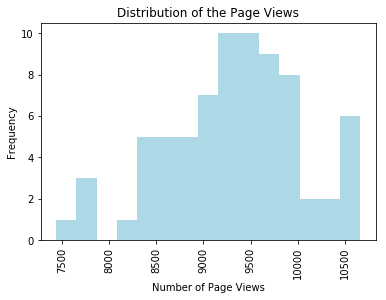

In [20]:
# Number of pagesviews 
plt.hist(dat.Pageviews, bins=15, color='lightblue')
plt.title('Distribution of the Page Views')
plt.ylabel('Frequency')
plt.xlabel('Number of Page Views')
plt.xticks(rotation='vertical')
plt.show()

In [21]:
# Sanity Check for Page Views

# Observed: Ncont / Ntotal
phat_views = dat[dat["Group"] == 0].sum()["Pageviews"]/dat.sum()["Pageviews"]

# Calculate the expected CIs based on CLT and the expected center 0.5
# SE based on the expected center of CI 0.5
p_views = 0.5
se_views = np.sqrt(p_views*(1-p_views)/(dat.sum()["Pageviews"]))

# CI
CI_lower_views = p_views - se_views*1.96
CI_upper_views = p_views + se_views*1.96

print(CI_lower_views, CI_upper_views, CI_lower_views < 0.5 and CI_upper_views > 0.5)

0.49882039214902313 0.5011796078509769 True


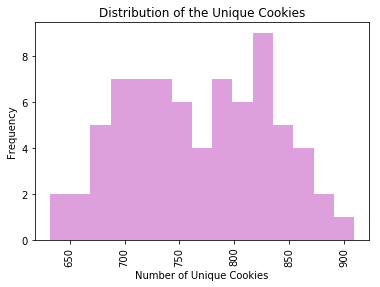

In [42]:
# Number of cookies  
plt.hist(dat.Clicks, bins=15, color='plum')
plt.title('Distribution of the Unique Cookies')
plt.ylabel('Frequency')
plt.xlabel('Number of Unique Cookies')
plt.xticks(rotation='vertical')
plt.show()

In [23]:
# Sanity Check for Clicks

# Ncont / Ntotal
phat_clicks = dat[dat["Group"] == 0].sum()["Clicks"]/dat.sum()["Clicks"]

# SE based on the expected center of CI 0.5
se_clicks = np.sqrt(0.5*0.5/(dat.sum()["Clicks"]))

# CI
CI_lower_clicks = 0.5 - se_clicks*1.96
CI_upper_clicks = 0.5 + se_clicks*1.96

print(CI_lower_clicks, CI_upper_clicks, CI_lower_clicks < 0.5 and CI_upper_clicks > 0.5)

0.49588449572378945 0.5041155042762105 True


As shown above, the distribution for the invariant metrics **number of cookies** and the **number of page views** seem to be normal, so we can assume the metrics follow the _Bernoulli_ distribution. Since the observed metrics are both included in the expected confidence intervals with the center of **0.5**, in other words, there is no significant difference in the two metrics in the control and experiment groups.

Reference: [Checking Invariants Part 2](https://classroom.udacity.com/courses/ud257/lessons/4085798776/concepts/40713087720923). 

#### Sanity check for CTP

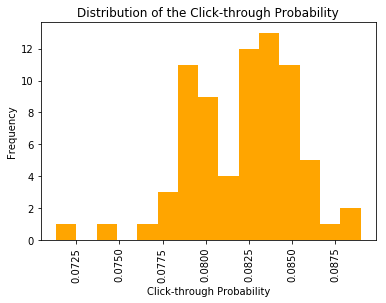

In [24]:
# CTP 
plt.hist(dat.Clicks/dat.Pageviews, bins=15, color='orange')
plt.title('Distribution of the Click-through Probability')
plt.ylabel('Frequency')
plt.xlabel('Click-through Probability')
plt.xticks(rotation='vertical')
plt.show()

The distribution for **CTP** appears to have two modes. So I decided to perform a bootstrapping test, and calculate the empirical confidence interval based on the differences in CTP between the control and experiment groups.   

In [25]:
# Boostrap relicate function 

def bootstrap_relicate_1d(data, func):
    # Generate bootstrap replicate of 1 dimensional data
    bs_sample = np.random.choice(data, len(data)) # bootstrap relicate, size = n
    return func(bs_sample)

In [26]:
cont_ctp = dat[dat["Group"] == 0]["Clicks"]/dat[dat["Group"]==0]["Pageviews"]
exp_ctp  = dat[dat["Group"] == 1]["Clicks"]/dat[dat["Group"]==1]["Pageviews"]

v0 = np.vstack((cont_ctp, exp_ctp)) # create an array 
d0 = v0[1] - v0[0]

# Bootstrap replicates 
bs_replicates0 = np.empty(1000)

for i in range(1000):
    bs_replicates0[i] = bootstrap_relicate_1d(d0, np.mean)

conf_int0 = np.percentile(bs_replicates0, [2.5, 97.5])

bci_lower0 = conf_int0[0]
bci_upper0 = conf_int0[1]

print(bci_lower0, bci_upper0)

-0.0005388856497911426 0.0006215252480994556


C:\Users\Ann\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


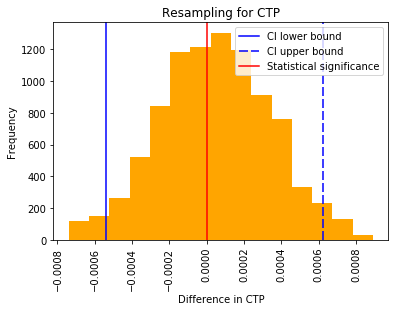

In [40]:
# Plot a histogram of bootstrap replicates

fig, ax = plt.subplots()

plt.hist(bs_replicates0, bins=15, normed = True, color='orange')
plt.xlabel('Difference in CTP')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')
plt.title('Resampling for CTP')

lu0 = plt.axvline(x=bci_lower0, c='b', label='CI lower bound')
ll0 = plt.axvline(x=bci_upper0, c='b', label='CI upper bound')
ll0.set_dashes([6,2])

ls0 = plt.axvline(x=0, c='r', label='Statistical significance')

ax.legend()
plt.show()

As shown on the graph above, if we repeat the experiment over and over again, the data CTP become normally distributed. Since 0 is captured in the 95% confidence interval from the bootstrapping test, we can conclude that there is no significant difference between the control and experiment groups with respect to this invariant metric. 

In summary, all three invariant metrics passed the sanity check. It is safe for us to continue our analysis. 

### Result Analysis 

#### 1. Effect Size Tests

For the evaluation metrics, **Gross Conversion** rate and **Net Conversion** rate, I am going to first of all calculate their analytic confidence intervals assuming they both come from the _bernoulli_ distribution. Second, I will reconstruct their confidence intervals using bootstrpping if their distributions look lopsided based on the data collected. 

Again, the data are available at: [Final Project Results](https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0). 

In [78]:
# Analytic confidence interval

def check_sig (x1, x2, n1, n2, alpha, dmin):
    
    p1 = x1/n1
    p2 = x2/n2
    
    #p_pool = (x1 + x2)/(n1 + n2)
    #se_pool = np.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
    
    t_alpha2 = scipy.stats.norm.isf(alpha/2)
    d = p2 - p1
    se_pool = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    
    CI_lower = round(d - se_pool*t_alpha2, 4)
    CI_upper = round(d + se_pool*t_alpha2, 4)

    # Calculate p-value
    t = d/se_pool
    df = n1+n2-2
    pval = scipy.stats.t.cdf(t, df=df)
    
    if CI_lower < 0 and CI_upper > 0:
        
        statistical_sig = 'N'

    else: 
        statistical_sig = 'Y'


    print ('\n',(1-alpha)*100, '% CI lower bound: ', CI_lower, 
           '\n', (1-alpha)*100, '% CI upper bound: ', CI_upper,
          '\n p-value: ', pval, 
           '\n Statistical significance: ', statistical_sig)

(1) Hypothesis for **Gross Conversion**:

$$H_0: p_1 = p_2$$
$$H_a: p_1 \neq p_2$$

It should be noted the practical difference is 0.01, which means there should be at least 1% change in Gross Conversion rate to launch the change. 

In [79]:
# Drop null values from the dataset
df = dat.dropna()

# Effect Size Test for Gross Conversion 

Xcont_enroll = df[df["Group"] == 0].sum()["Enrollments"]
Xexp_enroll  = df[df["Group"] == 1].sum()["Enrollments"]

Ncont_clicks = df[df["Group"] == 0].sum()["Clicks"]
Nexp_clicks  = df[df["Group"] == 1].sum()["Clicks"]

check_sig(Xcont_enroll, Xexp_enroll, Ncont_clicks, Nexp_clicks, 0.05, -0.01)


 95.0 % CI lower bound:  -0.0291 
 95.0 % CI upper bound:  -0.012 
 p-value:  1.28364660850983e-06 
 Statistical significance:  Y


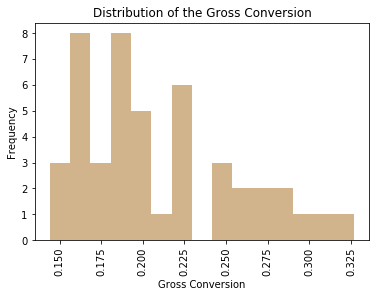

In [80]:
# Gross Conversion 
plt.hist(df.Enrollments/df.Clicks, bins=15, color='tan')
plt.title('Distribution of the Gross Conversion')
plt.ylabel('Frequency')
plt.xlabel('Gross Conversion')
plt.xticks(rotation='vertical')
plt.show()

The distribution for **Gross Conversion** is right skewed. So I am going to resample the data collected and double check the result. 

In [81]:
# Bootstrapping for Gross Conversion 

cont_gc = df[df["Group"]==0]["Enrollments"]/df[df["Group"]==0]["Clicks"]
exp_gc  = df[df["Group"]==1]["Enrollments"]/df[df["Group"]==1]["Clicks"]

v = np.vstack((cont_gc, exp_gc)) # create an array 
d = v[1] - v[0]

# Bootstrap replicates 
bs_replicates = np.empty(1000)

for i in range(1000):
    bs_replicates[i] = bootstrap_relicate_1d(d, np.mean)

conf_int = np.percentile(bs_replicates, [2.5, 97.5])

bci_lower = conf_int[0]
bci_upper = conf_int[1]

print(bci_lower, bci_upper)

-0.031228552655890928 -0.009841840072193152


C:\Users\Ann\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


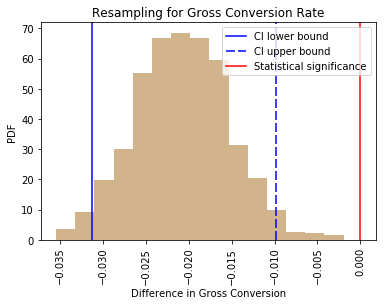

In [82]:
# Plot a histogram of bootstrap replicates

fig, ax = plt.subplots()

plt.hist(bs_replicates, bins=15, normed = True, color='tan')
plt.xlabel('Difference in Gross Conversion')
plt.ylabel('PDF')
plt.xticks(rotation='vertical')
plt.title('Resampling for Gross Conversion Rate')

lu = plt.axvline(x=bci_lower, c='b', label='CI lower bound')
ll = plt.axvline(x=bci_upper, c='b', label='CI upper bound')
ll.set_dashes([6,2])

ls = plt.axvline(x=0, c='r', label='Statistical significance')

ax.legend()
plt.show()

It appears that the empirical bootstrapping test agrees with the result from the analytic variation where both confidence interval does _not_ include 0, there is siginifcant statistical difference in **Gross Conversion** rate between the control and experiment groups. To be concrete, the gross conversion rate is significantly **lower in the experiment group** than that of the control group. 

(2) Hypothesis for **Net Conversion**:

$$H_0: p_1 = p_2$$
$$H_a: p_1 \neq p_2$$

It should be noted the practical difference is 0.0075, which means there should be at least 0.75% change in Gross Conversion rate to launch the change. 

In [83]:
# Effect Size Test for Net Conversion 

Xcont_pay = df[df["Group"] == 0].sum()["Payments"]
Xexp_pay  = df[df["Group"] == 1].sum()["Payments"]

check_sig(Xcont_pay, Xexp_pay, Ncont_clicks, Nexp_clicks, 0.05, 0.0075)


 95.0 % CI lower bound:  -0.0116 
 95.0 % CI upper bound:  0.0019 
 p-value:  0.07791518688005435 
 Statistical significance:  N


The _analytic confidence interval_ tells us there is no significant difference between the two groups as 0 is not included in the interval. The p-value agrees with the CI as it is greater than 0.05 significance level. 

Let's take a look at the histogram of the data collected in this experiment. 

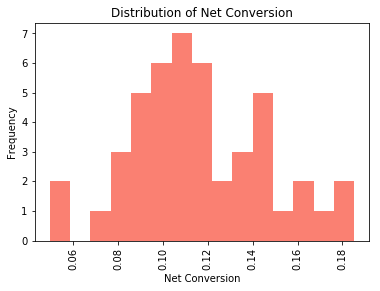

In [34]:
# Plot the distribution of net conversion 
plt.hist(df.Payments/df.Clicks, bins=15, color='salmon')
plt.title('Distribution of Net Conversion')
plt.ylabel('Frequency')
plt.xlabel('Net Conversion')
plt.xticks(rotation='vertical')
plt.show()

The distribution for Net Conversion rate seems to be normal, yet I am still going to resample the data collected to see if the result is robust.

In [35]:
cont_nc = df[df["Group"]==0]["Payments"]/df[df["Group"]==0]["Clicks"]
exp_nc  = df[df["Group"]==1]["Payments"]/df[df["Group"]==1]["Clicks"]

v2 = np.vstack((cont_nc, exp_nc)) # create an array 
d2 = v2[1] - v2[0]

# Bootstrap replicates 
bs_replicates2 = np.empty(1000)

for i in range(1000):
    bs_replicates2[i] = bootstrap_relicate_1d(d2, np.mean)

conf_int2 = np.percentile(bs_replicates2, [2.5, 97.5])

bci_lower2 = conf_int2[0]
bci_upper2 = conf_int2[1]

print(bci_lower2, bci_upper2)

-0.017929545153322353 0.008215699337871026


C:\Users\Ann\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


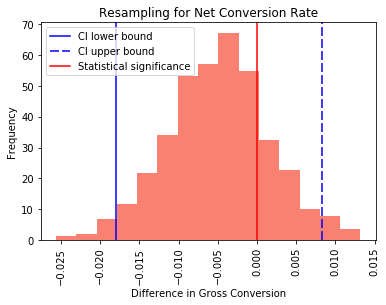

In [36]:
# Plot a histogram of bootstrap replicates

fig, ax = plt.subplots()

plt.hist(bs_replicates2, bins=15, normed = True, color='salmon')
plt.xlabel('Difference in Gross Conversion')
plt.ylabel('Frequency')
plt.xticks(rotation='vertical')
plt.title('Resampling for Net Conversion Rate')

lu2 = plt.axvline(x=bci_lower2, c='b', label='CI lower bound')
ll2 = plt.axvline(x=bci_upper2, c='b', label='CI upper bound')
ll2.set_dashes([6,2])

ls2 = plt.axvline(x=0, c='r', label='Statistical significance')

ax.legend()
plt.show()

As shown above, even if we resampled the data, there still is no significant statistical difference in **Net Conversion** between the control and experiment groups, since 0 is within the reconstructed confidence interval.  

#### 2. Sign Tests

Sign test is used to test for consistent differences between pairs of observations. In our experiment, we can assume that the probablity of getting a postive difference is 0.5. The null hypothesis is: there is no difference among the signs of two groups. 

In [37]:
# Count if difference is positive 
ct_gc = sum(1 if x > 0 else 0 for x in d)

# Sign test for Gross Conversion 
scipy.stats.binom_test(ct_gc, n=len(d), p=0.5, alternative='two-sided')

0.0025994777679443364

In [39]:
# Count if difference is positive
ct_nc = sum(1 if x > 0 else 0 for x in d2)

# Sign test for Net Conversion 
scipy.stats.binom_test(ct_nc, n=len(d2), p=0.5, alternative='two-sided')

0.6776394844055175

The p-value for **Gross Conversion** appears to be less than 0.05, which means there was a significant difference between the control and experiment groups in this metric. On the contrary, the p-value for _Net Conversion_ is greater than 0.05, so it is not statistically significant. 

#### 3. Summary 

In summary, I did not use Bonferroni Correction and the reasons are stated in the _Sizing_ section. There is no conflict between the effect size tests and the sign tests for the evaluation metrics. 

### Recommendation

To conclude, I would recommend launch the free trial screener, as the experiment has passed sanity checks, and the evaluation metric **Gross Conversion** rate has set up clearer expectations for students and _decreased_ the percentage of frustrated students enrolled in the courses as expected.  

## Part IV: Follow-Up Experiment

In this experiment, I ended up using only **Gross Conversion** rate as the evaluation metric. Since it showed a significant result, I would suggest perform a retrospective analysis on **Gross Conversion** and see how it improves along the way. 

If time allowed, I would suggest run the experiment for a few more weeks to see if there is any learning effect on the **Net Conversion** rate. I would also consider breaking down the data, such as by platform and by day of week, to see if there is _Simpson's Paradox_ or system setup issues that we missed at the data collection stage. 